Rows in 2023 public accounting (unweighted): 1222
Weighted total workers (sum of weights): 2980042.07
Industry codes present: [7270, 7280]


,MONTH,unweighted,weighted
0,3,1222,2980042.07


,sex,unweighted,weighted
0,Female,735,1752519.77
1,Male,487,1227522.30


/var/folders/7r/jdy_46yn31v2505350ttjpym0000gn/T/ipykernel_73036/12394749.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_age_unw = d.groupby("age_band").size().rename("unweighted").reset_index()
/var/folders/7r/jdy_46yn31v2505350ttjpym0000gn/T/ipykernel_73036/12394749.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_age_w = d.groupby("age_band")[wt_col].sum().rename("weighted").reset_index()


,age_band,unweighted,weighted
0,18–29,180,528345.81
1,30–44,441,995014.94
2,45–64,437,1023965.51
3,65+,164,432715.81


,STATEFIP,unweighted,weighted
4,6,117,306657.74
9,12,86,286848.92
32,36,71,253165.94
43,48,59,210338.16
13,17,47,172525.33
38,42,38,144501.15
21,25,52,121671.18
30,34,34,116945.49
46,51,29,94290.49
33,37,25,86657.78


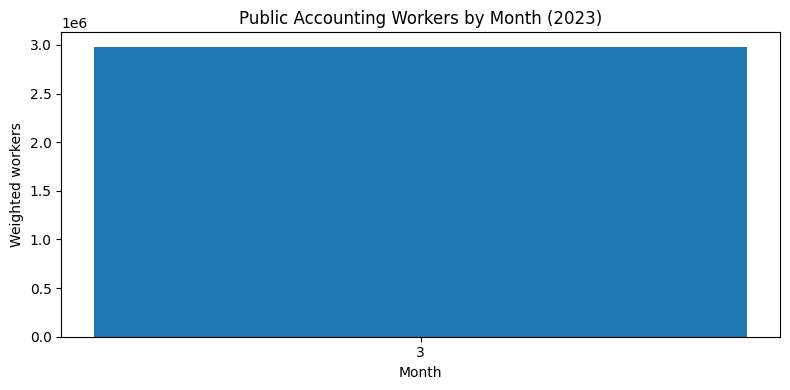

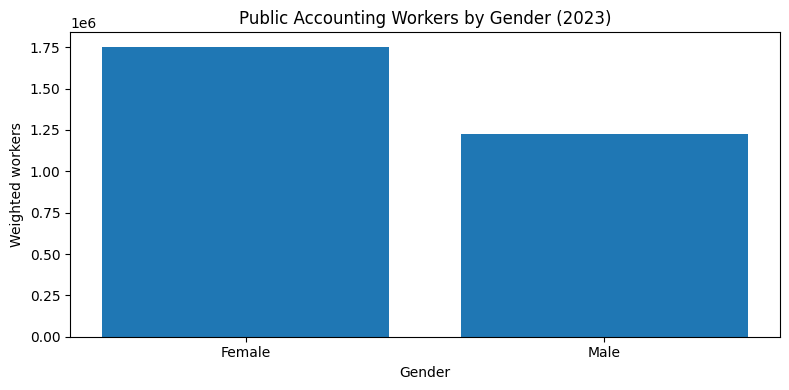

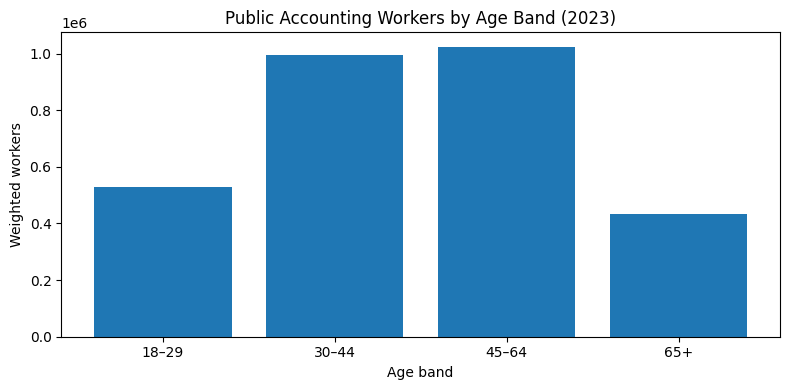

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load & set up
# -----------------------------
FILE = "cps_00003.csv"  # <-- change to your file name
df = pd.read_csv(FILE, low_memory=False)

def pick(colnames):
    for c in colnames:
        if c in df.columns:
            return c
    raise KeyError(f"None of {colnames} found. First 20 cols: {list(df.columns)[:20]}")

year_col   = pick(["YEAR"])
age_col    = pick(["AGE","AGEP"])
sex_col    = pick(["SEX"])
state_col  = pick(["STATEFIP","ST"])
ind_col    = pick(["IND","INDP"])                 # CPS often IND; ACS often INDP
wt_col     = next((c for c in ["ASECWT","WTFINL","PWGTP"] if c in df.columns), None)

# CPS (2017/2022 Census industry recodes): accounting = 7270; ACS often 7280.
PUBLIC_ACCT = {7270, 7280}

# -----------------------------
# 2) Filter to 2023 adults & public accounting
# -----------------------------
d = df[(df[year_col] == 2023) & (df[age_col] >= 18)].copy()

# If your extract has labeled strings for industry, try this instead:
# d = d[d[ind_col].astype(str).str.contains("Accounting|Bookkeeping|Payroll|Tax", case=False, na=False)]

d = d[d[ind_col].isin(PUBLIC_ACCT)].copy()

# Map sex codes to labels if numeric
if pd.api.types.is_numeric_dtype(d[sex_col]):
    d["sex"] = d[sex_col].map({1: "Male", 2: "Female"}).fillna(d[sex_col].astype(str))
else:
    d["sex"] = d[sex_col]

# Age bands
bins  = [18, 30, 45, 65, 200]
labs  = ["18–29", "30–44", "45–64", "65+"]
d["age_band"] = pd.cut(d[age_col], bins=bins, labels=labs, right=False)

# Weight helper
def wsum(s):
    return s if wt_col is None else s[wt_col].sum()

# -----------------------------
# 3) Quick diagnostics
# -----------------------------
print("Rows in 2023 public accounting (unweighted):", len(d))
if wt_col:
    print("Weighted total workers (sum of weights):", d[wt_col].sum())

print("Industry codes present:", sorted(d[ind_col].unique().tolist()))

# -----------------------------
# 4) Tables you can use
# -----------------------------
# by month (CPS has MONTH)
if "MONTH" in d.columns:
    by_month_unw = d.groupby("MONTH").size().rename("unweighted").reset_index()
    if wt_col:
        by_month_w = d.groupby("MONTH")[wt_col].sum().rename("weighted").reset_index()
        by_month = by_month_unw.merge(by_month_w, on="MONTH", how="left")
    else:
        by_month = by_month_unw
    display(by_month.head(12))

# by sex
by_sex_unw = d.groupby("sex").size().rename("unweighted").reset_index()
if wt_col:
    by_sex_w = d.groupby("sex")[wt_col].sum().rename("weighted").reset_index()
    by_sex = by_sex_unw.merge(by_sex_w, on="sex", how="left")
else:
    by_sex = by_sex_unw
display(by_sex)

# by age band
by_age_unw = d.groupby("age_band").size().rename("unweighted").reset_index()
if wt_col:
    by_age_w = d.groupby("age_band")[wt_col].sum().rename("weighted").reset_index()
    by_age = by_age_unw.merge(by_age_w, on="age_band", how="left")
else:
    by_age = by_age_unw
display(by_age)

# by state (top 10 by weighted)
by_state_unw = d.groupby(state_col).size().rename("unweighted").reset_index()
if wt_col:
    by_state_w = d.groupby(state_col)[wt_col].sum().rename("weighted").reset_index()
    by_state = by_state_unw.merge(by_state_w, on=state_col, how="left").sort_values("weighted", ascending=False)
else:
    by_state = by_state_unw.sort_values("unweighted", ascending=False)
display(by_state.head(10))

# Save tidy outputs
by_sex.to_csv("public_acct_2023_by_sex.csv", index=False)
by_age.to_csv("public_acct_2023_by_ageband.csv", index=False)
by_state.to_csv("public_acct_2023_by_state.csv", index=False)
if "MONTH" in d.columns:
    by_month.to_csv("public_acct_2023_by_month.csv", index=False)

# -----------------------------
# 5) Bar charts (weighted if available)
# -----------------------------
def bar(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8,4))
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Month chart
if "MONTH" in d.columns:
    y = by_month["weighted"] if wt_col else by_month["unweighted"]
    bar(by_month["MONTH"].astype(str), y,
        "Public Accounting Workers by Month (2023)",
        "Month", "Weighted workers" if wt_col else "Unweighted cases")

# Sex chart
y = by_sex["weighted"] if wt_col else by_sex["unweighted"]
bar(by_sex["sex"], y,
    "Public Accounting Workers by Gender (2023)",
    "Gender", "Weighted workers" if wt_col else "Unweighted cases")

# Age-band chart
y = by_age["weighted"] if wt_col else by_age["unweighted"]
bar(by_age["age_band"].astype(str), y,
    "Public Accounting Workers by Age Band (2023)",
    "Age band", "Weighted workers" if wt_col else "Unweighted cases")
